In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from tree import param_grid, best_model

csv_path = Path("./Housing.csv")
df = pd.read_csv(csv_path)


target_col = 'price'


y = df[target_col].values
X = df.drop(columns=[target_col])

numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(exclude="number").columns.tolist()

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median"))])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("cat", categorical_tf, categorical_features),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Target:", target_col)
print("Numeric:", len(numeric_features), "| Categorical:", len(categorical_features))

Target: price
Numeric: 6 | Categorical: 6


In [2]:
gbr = GradientBoostingRegressor(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("gbr", gbr),
])

param_grid = {
    "gbr__learning_rate": [.05, 0.1],
    "gbr__max_depth": [2, 3, 4],
    "gbr__min_samples_split": [2, 5, 10],
    "gbr__min_samples_leaf": [1, 3, 5],
    "gbr__n_estimators": [300, 500],
    "gbr__subsample": [1.0, 0.8],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid,
                  scoring="neg_mean_squared_error", cv=cv,
                  n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
best_model = gs.best_estimator_
print(gs.best_params_)

{'gbr__learning_rate': 0.05, 'gbr__max_depth': 4, 'gbr__min_samples_leaf': 3, 'gbr__min_samples_split': 2, 'gbr__n_estimators': 300, 'gbr__subsample': 0.8}


In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

y_pred_gbr = best_model.predict(X_test)
print("Gradient Boosting Regressor:")
print(f"R^2 (test): {r2_score(y_test, y_pred_gbr):.4f}")
print(f"RMSE (test): {rmse(y_test, y_pred_gbr):.4f}")

Gradient Boosting Regressor:
R^2 (test): 0.6746
RMSE (test): 14745.3250


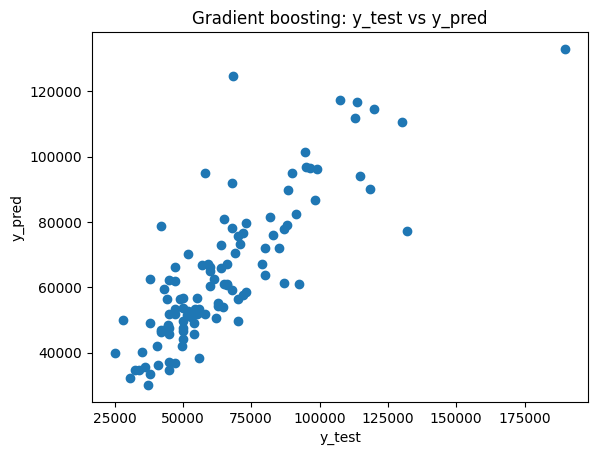

In [5]:
plt.figure()
plt.scatter(y_test, y_pred_gbr)
plt.title("Gradient boosting: y_test vs y_pred")
plt.xlabel("y_test"); plt.ylabel("y_pred")
plt.show()

In [6]:
oh = best_model.named_steps["prep"].transformers_[1][1].named_steps["onehot"] if categorical_features else None
num_names = numeric_features
cat_names = oh.get_feature_names_out(categorical_features).tolist() if oh is not None else []
feature_names = num_names + cat_names

importances = best_model.named_steps["gbr"].feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names if len(feature_names)==len(importances) else [f"f{i}" for i in range(len(importances))],
    "importance": importances
}).sort_values("importance", ascending=False).head(15)

imp_df

,feature,importance
1,lotsize,0.381049
0,rownames,0.177823
3,bathrms,0.122440
5,garagepl,0.071163
4,stories,0.052161
15,airco_yes,0.039844
2,bedrooms,0.033433
14,airco_no,0.032938
10,fullbase_no,0.018975
11,fullbase_yes,0.018267


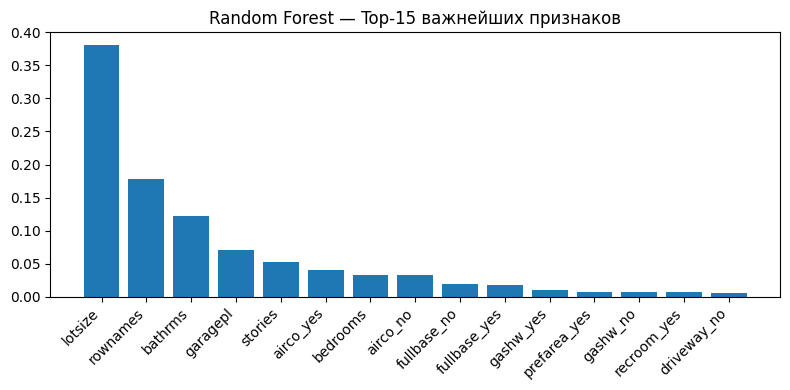

In [7]:
plt.figure(figsize=(8,4))
plt.bar(imp_df["feature"], imp_df["importance"])
plt.title("Random Forest — Top-15 важнейших признаков")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()